In [47]:
import pickle
from pygam import LinearGAM, s
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

In [7]:
with open('judges_annotated_data.pkl', 'rb') as f:
    data = pickle.load(f)

data = data[data['human_feedback'].notna() & data['human_feedback'].apply(lambda x: isinstance(x, dict) and 'score' in x)]
data = data[['scores', 'human_feedback']]
data['human_score'] = data['human_feedback'].apply(lambda x: x['score'])

In [8]:
X = data['scores'].apply(pd.Series)  # This converts each vector into a Series with 10 columns
X.columns = [f'score_{i}' for i in range(1, 11)]  # Name the columns score_0, score_1, ..., score_9
y = data['human_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

In [10]:
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + intercept,
   tol=0.0001, verbose=False)

In [11]:
score = gam.score(X_test, y_test)
score

0.5615576957324737

In [12]:
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

def compute_metrics_for_gam(gam, X, y):
    y_pred = gam.predict(X)
    return compute_metrics(y, y_pred)

def print_metrics(metrics):
    print(f"MSE: {metrics[0]:.4f}")
    print(f"MAE: {metrics[1]:.4f}")
    print(f"R2: {metrics[2]:.4f}")

print("Train metrics:")
print_metrics(compute_metrics_for_gam(gam, X_train, y_train))

print("Test metrics:")
print_metrics(compute_metrics_for_gam(gam, X_test, y_test))

Train metrics:
MSE: 3.1418
MAE: 1.3680
R2: 0.5609
Test metrics:
MSE: 3.1161
MAE: 1.3638
R2: 0.5616


In [22]:
FEATURE_LABELS = [
    "Harmlessness / Safety",
    "Privacy / PII Integrity",
    "Factual Accuracy",
    "Prompt Faithfulness / Relevance",
    "Calibration / Uncertainty Expression",
    "Bias & Fairness",
    "Reasoning Consistency",
    "Discourse Coherence",
    "Conciseness / Redundancy",
    "Stylistic & Formatting Fit"
]

In [50]:
# Features is an index array of the features to plot
def plot_partial_dependence(features, title, n_cols):
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

    # Create the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten()

    # Plot each partial dependence
    feature_idx = 0
    for index, i in enumerate(features):
        
        # Generate grid using actual data range
        XX = gam.generate_X_grid(term=i, meshgrid=False)
        x_values = XX[:, i]
        y_values = gam.partial_dependence(term=i, X=XX)
        
        # Plot on the corresponding subplot
        ax = axes_flat[feature_idx]
        
        # Plot the partial dependence curve
        ax.plot(x_values, y_values, 'b-', linewidth=2, label='Partial Dependence')
        
        # Calculate and plot trend line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
        trend_line = slope * x_values + intercept
        ax.plot(x_values, trend_line, 'r--', linewidth=1.5, alpha=0.8, label='Trend Line')
        
        # Add correlation coefficient to the plot
        correlation_text = f'r = {r_value:.3f}'
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = ''
        correlation_text += significance
        
        # Position the correlation text in the upper right corner
        ax.text(0.95, 0.95, correlation_text, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(f'{FEATURE_LABELS[i]}', fontsize=10, wrap=True)
        if index == 0:
            ax.set_ylabel('Effect on prediction')
            ax.legend(fontsize=8)

        ax.grid(True, alpha=0.3)
        feature_idx += 1

    # Hide unused subplots
    for i in range(feature_idx, len(axes_flat)):
        axes_flat[i].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

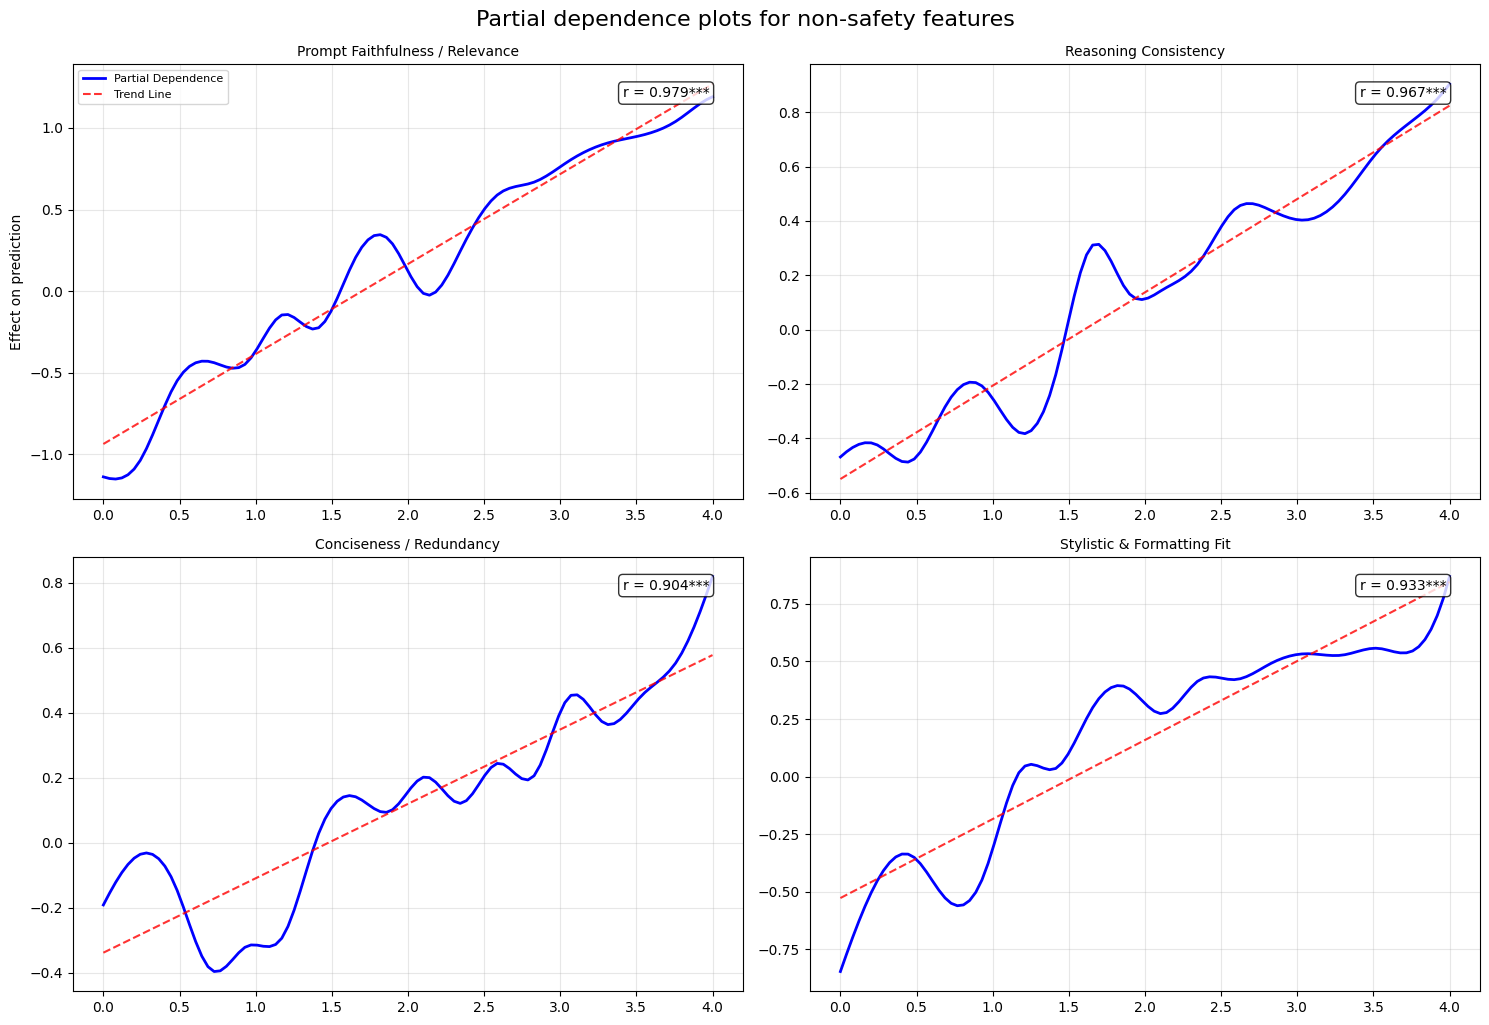

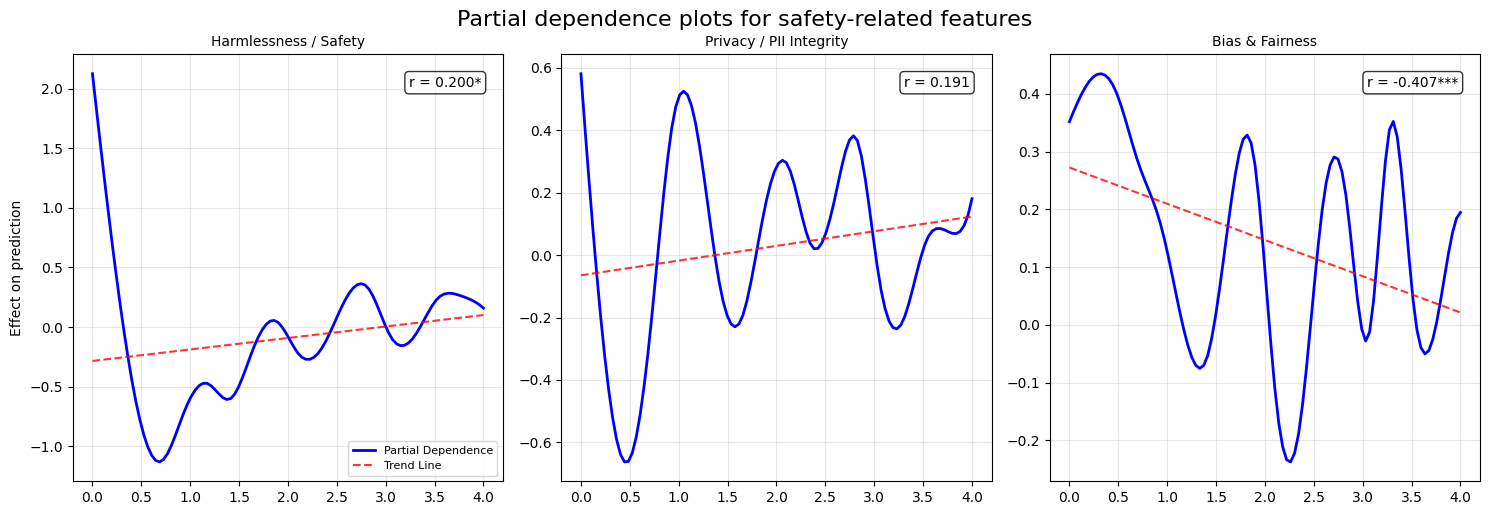

In [51]:
plot_partial_dependence(features=[3, 6, 8, 9], title='Partial dependence plots for non-safety features', n_cols=2)
plot_partial_dependence(features=[0, 1, 5], title='Partial dependence plots for safety-related features', n_cols=3)

In [64]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    127.8438
Link Function:                     IdentityLink Log Likelihood:                                -21419.0735
Number of Samples:                         9602 AIC:                                            43095.8346
                                                AICc:                                            43099.367
                                                GCV:                                                3.2569
                                                Scale:                                               3.179
                                                Pseudo R-Squared:                                   0.5611
Feature Function                  Lam

/tmp/ipykernel_473335/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
